# COS30049 Assignment 2 - Group 8


## Data Processing
### Importing requirements

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

### Loading the first dataset into a dataframe
The first dataset we will be loading is the email dataset, this dataset is provided publicly on Kaggle but will require some cleaning and normalization before it can be used.

In [81]:
# Load the dataset into a dataframe
email_df = pd.read_csv('datasets/completeSpamAssassin.csv', index_col=0)

### Data Cleaning: Removing rows with missing values

Based on the documentation provided with the dataset on Kaggle, 9% of rows have 'empty' as the 'Body' part of the row. This isn't going to be very helpful for our model training therefore we must remove these rows from the dataset.

In [82]:
# Removal of the rows with 'empty' in the 'Body' column
email_df = email_df[email_df['Body'] != 'empty']

email_df = email_df.dropna()

print(len(email_df))

5512


Instead of the label column being 1 for spam and 0 for ham, we'd like it to actually contain the words 'spam' and 'ham'

In [83]:

# Map 'spam' to 1 and 'ham' to 0
email_df['Label'] = email_df['Label'].map({1: 'spam', 0: 'ham'})

### Loading the second dataset into a new dataframe
The second dataset which will be used is the spam SMS dataset also provided on Kaggle. This dataset appears to be clean already and ready to use, te only change that needs to be made it changing the column names to match the first dataset, asewell as removing unused columns.

In [84]:
# Loading the second dataset into a new dataframe
sms_df = pd.read_csv('datasets/spam.csv', encoding='latin-1')

In [85]:
# Keep only the columns we need and rename them to match the first dataframe
sms_df = sms_df[['v1', 'v2']]
sms_df = sms_df.rename(columns={'v1': 'Label', 'v2': 'Body'})

### Joining the two dataframes together

In [86]:
df = pd.concat([email_df, sms_df], ignore_index=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11084 entries, 0 to 11083
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    11084 non-null  object
 1   Label   11084 non-null  object
dtypes: object(2)
memory usage: 173.3+ KB
None
                                                Body Label
0  \nSave up to 70% on Life Insurance.\nWhy Spend...  spam
1  1) Fight The Risk of Cancer!\nhttp://www.adcli...  spam
2  1) Fight The Risk of Cancer!\nhttp://www.adcli...  spam
3  ##############################################...  spam
4  I thought you might like these:\n1) Slim Down ...  spam


## Data Analysis
### Bar chart to visualise the number of spam messages vs non spam messages

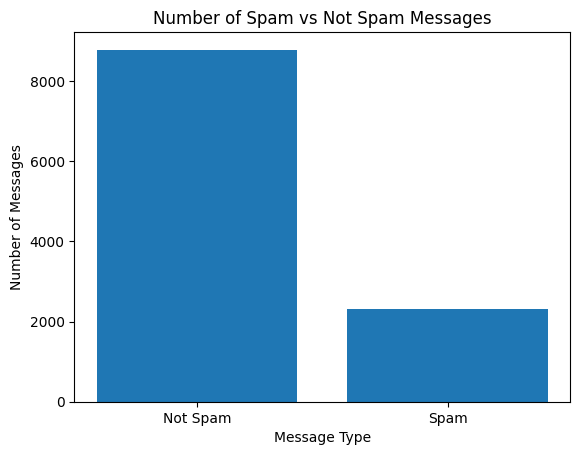

In [87]:
occurence_counts = df['Label'].value_counts()
plt.bar(occurence_counts.index, occurence_counts.values)
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.xlabel('Message Type')
plt.ylabel('Number of Messages')
plt.title('Number of Spam vs Not Spam Messages')
plt.show()

## Model Training

### Classification

In [88]:
def add_features(df):
    df = df.copy()
    df['num_chars'] = df['Body'].str.len()
    df['num_special_chars'] = df['Body'].str.count(r'[!@#$%^&*(),.?":{}|<>]')
    df['word_count'] = df['Body'].str.split().apply(len)
    return df[['num_chars', 'num_special_chars', 'word_count']]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df[['Body']], df['Label'], test_size=0.2, random_state=42)

In [90]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Body'),  # text features
        ('num', Pipeline([
            ('features', FunctionTransformer(add_features, validate=False)),
            ('scaler', StandardScaler())
        ]), ['Body'])  # numeric features extracted from 'Body'
    ]
)

In [91]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [92]:
# --- Train ---
clf.fit(X_train, y_train)

# --- Evaluate ---
print("Training Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

Training Accuracy: 0.9742866809518439
Test Accuracy: 0.9675236806495264


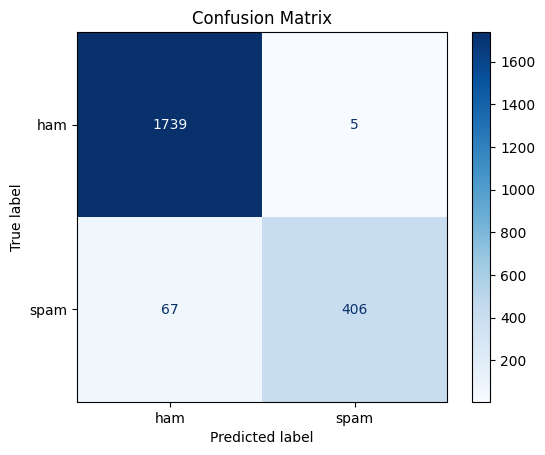

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Predictions
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
